# Stable topic calculation

may be performed for a variety of stable topic thresholds. This program takes a while to run..

In [1]:
import json
import pandas as pd
import numpy as np
import sys

from sklearn.metrics.pairwise import cosine_similarity

sys.path.append("../src")
from process import *

## Config

In [2]:
# default threshold for determination of keyword relevancy in topic based on 'logprob'
# value must be this value or higher (positive direction)
Def_Keyword_Logprob_Threshold = -2.5

# actual LPT to use
Lpt=-2.0

# Run Series 
Series = '19_2' # '19'
Topics = 125
Runs = ['rec1', 'rec2', 'rec3', 'rec4', 'rec5', 'rec6', 'rec7', 'rec8', 'rec9', 'rec10', ]

## Code

In [3]:

def calc_similarity (vec:list)->float:
    ''' calculate cosine similarity for 2 documents '''
    result_matrix = cosine_similarity(np.array([vec[0]]), np.array([vec[1]])) 
    
    # return doc1->doc2 similarity 
    return result_matrix[0][0]

def vectorize(df1, df2)->list:
    data1 = {row[1]['Term']:[int(row[1]['Freq'])] for row in df1.iterrows() }
    data2 = {row[1]['Term']:[int(row[1]['Freq'])] for row in df2.iterrows() }
    
    for k,v in data2.items():
        if k in data1:
            data1[k].append(v[0])
        else:
            data1[k] = [0, v[0]]
    
    for k in data1.keys():
        if not k in data2:
            data1[k].append(0)
            
    df = pd.DataFrame(data1, index = ['doc1', 'doc2'])
    m = []
    for r in df.iterrows():
        m.append(list(r[1]))
        
    return m

def get_topic_keywords(series:str, run:str, n_topics:int):
    
    version = f"{series}_{n_topics}_{run}"
    return openlda_viz(version)
    
    
def topic_keywords(topic:int, lda_viz_data:pd.DataFrame)->str:
    topic_keys = lda_viz_data[lda_viz_data['Category']== f'Topic{topic}']
    sorted_keys = topic_keys.sort_values(by="logprob", ascending=False)

    # capture keywords
    terms = []
    for i in range(0, len(sorted_keys)):
        new_term = sorted_keys[i:i+1]['Term'].to_string(index=False).strip()
        terms.append(new_term)
        
    return ",".join(terms) 

def read_timeseries(series:str, run:str, n_topics:int):
    df = open_timeseries(f"{series}_{n_topics}_{run}")
    #timeseries_filename = f"../data/time_series_characteristics_{series}_{n_topics}_{run}.csv"
    #df = pd.read_csv(timeseries_filename)
    return df[['CAGR', 'count']]

def merge_ts_keywords(ts:pd.DataFrame, viz_data:pd.DataFrame)->pd.DataFrame:
    
    topics = [t for t in range(0, len(ts))]
    keys = [topic_keywords(t, viz_data) for t in topics]
    cagr = [c for c in ts['CAGR']]
    count = [c for c in ts['count']]
    
    res = pd.DataFrame({'topic':topics, 'keywords':keys, 'cagr': cagr, 'count': count})
    
    return res

def create_data(series:str, run:str, n_topics:int, lpt:float)->pd.DataFrame:
    
    # 1. get the LDA topic keywords
    lda_viz_data = get_topic_keywords(series, run, n_topics)
    # filter out all stuff which is below our logprob threshold (lpt)
    filt_data = lda_viz_data[lda_viz_data['logprob'] >= lpt]
    
    #2. Get the timeseries data wi/ CAGR, counts info
    ts = read_timeseries(series, run, n_topics)
    
    #3. Merge these data and return
    return merge_ts_keywords(ts, filt_data)


# Load data which contain mapping of top keywords to topics
def load_pylda_vis_data (num_topic:int=125, run:str='rec1'):
    version = f"{Series}_{num_topic}_{run}" 
    return openlda_viz(version)


def find_relevant_keywords(topic:int, lda_viz_data:pd.DataFrame, 
                           logprob_thresh:float=Def_Keyword_Logprob_Threshold,
                          )->pd.DataFrame:
    
    # 'freq' is how much it occurs in this particular topic, 
    # 'total' is how frequent it appears across all topics in this run
    # We can try to find top keywords for topic based on freq it occurs and drop-off in probability.
    # Hueristic: logprob >= threshold
    
    result = lda_viz_data[lda_viz_data['Category']== f'Topic{topic}']
    result = result[result['logprob']>=logprob_thresh]  
    
    # return pairs of terms and their count in the topic (Freq)
    return result[['Term', 'Freq']]


def find_relatedness (run1:str, run2:str, n_topics:int, lpt:float=Def_Keyword_Logprob_Threshold, series:str='19')->pd.DataFrame:
    
    data1 = create_data(Series, run1, n_topics, lpt)
    data2 = create_data(Series, run2, n_topics, lpt)

    lda_viz_data1 = load_pylda_vis_data(n_topics, run1)
    data1_keywords = { t:find_relevant_keywords(t, lda_viz_data1, lpt) for t in range(0, n_topics)}
    
    lda_viz_data2 = load_pylda_vis_data(n_topics, run2)
    data2_keywords = { t:find_relevant_keywords(t, lda_viz_data2, lpt) for t in range(0, n_topics)}
    
    # clean out empty sets and return
    x1 = relatedness(data1, data1_keywords, data2, data2_keywords)
    #topics_to_discard = [r[0] for r in x1.iterrows() if len(r[1]['keywords']) == 0]
    
    return x1


def find_scores(num_topics:int, runs:list, lpt:float=Def_Keyword_Logprob_Threshold)->dict:
    
    """ generate data for all runs compared to each other """

    results = {}
    for runA in runs:
        for runB in runs:
            if runA != runB:
                # find relatedness between runA & runB
                results[f'{runA}-{runB}'] = find_relatedness(runA, runB, num_topics, lpt)
                    
    return results


def calc_relatedness (topic_words1:dict, topic_words2:dict)->list:
    
    """ Compare 2 lists of topics which comprise sets of keywords
        to determine how related they are 
    """
    topics = topic_words1.keys()
    best_topic2 = -1
    best_relate_val_list = []
    best_topic2_list = []
    
    for t1 in topics: 
        w_df1 = topic_words1[t1]
        best_related_val = 0.
        size1 = len(w_df1)
        if size1 > 0:
            for t2 in topics:
                w_df2 = topic_words2[t2]
                if len(w_df2) > 0:
                    rel_val = calc_similarity(vectorize(w_df1, w_df2))
                else:
                    rel_val = 0.

                if rel_val > best_related_val:
                    best_related_val = rel_val
                    best_topic2 = t2

        best_relate_val_list.append(best_related_val)
        best_topic2_list.append(best_topic2)
    
    return pd.DataFrame({'topic':topics, 'best_topic2':best_topic2_list, 'relatedness':best_relate_val_list})


def relatedness (data1:pd.DataFrame, data1_keywords:dict, 
                 data2:pd.DataFrame, data2_keywords:dict)->pd.DataFrame:
    
    """ The relatedness of data1 to data2. 
        Converse is not necessarily exactly the same.
    """
     
    return calc_relatedness (data1_keywords, data2_keywords)

def related_score(results:pd.DataFrame)->float:
    # Overall adding of relatedness / number of rows as a metric
    try:
        return sum(list(results['relatedness']))/len(results)
        
    except ZeroDivisionError:
        
        # no results so relatedness is irrelevant?
        return -1.


## Process

In [4]:
# generate/calculate the basic cosine similarity between all topics in all runs
r = find_scores(Topics, Runs, lpt=Lpt)

In [5]:
# write to disk
for k in r.keys():
    r[k].to_csv(f"../results/topic_best_related_{Series}_{Topics}_{k}.csv", index=False)

In [7]:
import statistics as stat
# calculate the mean relatedness 
topics = range(0, Topics)
mean_related = {run:{t:-1 for t in topics} for run in Runs}
    
for runA in Runs:
    relatedness = {t:[] for t in topics}
    for runB in Runs:
        result = {}
        if runA != runB:
            filename = f'../results/topic_best_related_{Series}_{Topics}_{runA}-{runB}.csv'
            data = pd.read_csv(filename) #r[filename]
            for t1 in topics:
                relatedness[t1].append(float(data[data['topic']==t1]['relatedness']))
                
    mean_related[runA] = {t:stat.mean(relatedness[t]) for t in topics}

/tmp/ipykernel_5899/1922491474.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  relatedness[t1].append(float(data[data['topic']==t1]['relatedness']))
/tmp/ipykernel_5899/1922491474.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  relatedness[t1].append(float(data[data['topic']==t1]['relatedness']))
/tmp/ipykernel_5899/1922491474.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  relatedness[t1].append(float(data[data['topic']==t1]['relatedness']))
/tmp/ipykernel_5899/1922491474.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  relatedness[t1].append(float(data[data['topic']==t1]['rela

In [8]:
#mean_related['rec1']

In [9]:
# find most stable topics in a run
stable_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for run in Runs:
    stable_topics = {f'{thresh}':[] for thresh in stable_thresholds}
    for thresh in stable_thresholds:
        for t in mean_related[run].keys():
            if mean_related[run][t] >= thresh:
                stable_topics[f'{thresh}'].append(t)

    # write out results
    data = pd.DataFrame({'topics':[v for v in stable_topics.values()], 'threshold': stable_thresholds})
    data.to_csv(f'../data/stable_topics_{Series}_{Topics}_{run}_lp{Lpt}.csv', index=False)
data

,topics,threshold
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.1
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.2
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.3
3,"[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 1...",0.4
4,"[1, 3, 4, 7, 8, 10, 11, 13, 17, 19, 21, 22, 24...",0.5
5,"[1, 3, 4, 8, 10, 11, 17, 19, 21, 24, 25, 30, 3...",0.6
6,"[3, 8, 10, 11, 17, 21, 24, 25, 30, 33, 34, 38,...",0.7
7,"[3, 8, 10, 17, 21, 24, 25, 30, 33, 34, 45, 69,...",0.8
8,"[10, 25, 33, 45, 69, 97, 117]",0.9


In [14]:
test = pd.read_csv(f'../data/stable_topics_{Series}_{Topics}_rec10_lp{Lpt}.csv')
test

,topics,threshold
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.1
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.2
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.3
3,"[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 1...",0.4
4,"[1, 3, 4, 7, 8, 10, 11, 13, 17, 19, 21, 22, 24...",0.5
5,"[1, 3, 4, 8, 10, 11, 17, 19, 21, 24, 25, 30, 3...",0.6
6,"[3, 8, 10, 11, 17, 21, 24, 25, 30, 33, 34, 38,...",0.7
7,"[3, 8, 10, 17, 21, 24, 25, 30, 33, 34, 45, 69,...",0.8
8,"[10, 25, 33, 45, 69, 97, 117]",0.9


In [15]:
foo = test[test['threshold']==0.5]
type(foo)
str_val = foo['topics'].to_list()[0]
str_val = str_val[1:]
str_val = str_val[:-1]
stable_vals = str_val.split(',')
#stable_vals

## Plot Results

In [16]:
# plot and collect results
import matplotlib.pyplot as plt
%matplotlib inline
    
def collect_results(mean_related:dict)->pd.DataFrame:
    
    collected = []
    for run in Runs:
        data = mean_related[run]
        collected.extend(data.values())

    return collected

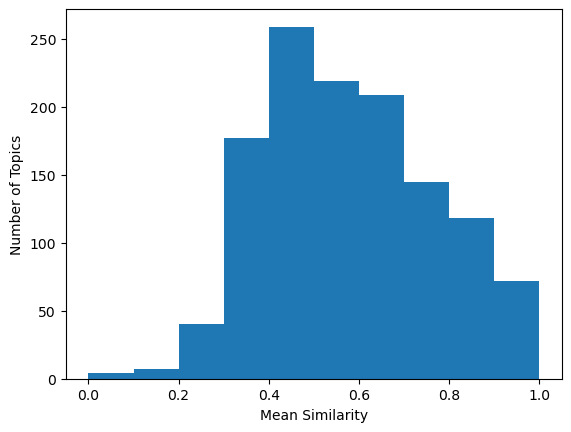

In [17]:
# plot a histogram of mean relatedness for all runs
data = collect_results(mean_related)
bins = [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]
plt.hist(data, bins)
plt.xlabel("Mean Similarity")
plt.ylabel("Number of Topics")
plt.savefig(f'../plots/mean_similar_diagram_lp{Lpt}.jpg', transparent=False, dpi=600)

In [18]:
# get numbers for the distribution
d = pd.DataFrame({'mean_related':data})
total_rel = len(data)
for b in range(0, len(bins)-1):
    b1 = bins[b]
    b2 = bins[b+1]
    
    foo = d[d['mean_related'] <= b2]
    n = len(foo[foo['mean_related'] > b1])
    fr = n/total_rel
    
    print(f'{b1*100}% to {b2*100}%: {n} ({fr:4.2f}%)')

0.0% to 10.0%: 0 (0.00%)
10.0% to 20.0%: 7 (0.01%)
20.0% to 30.0%: 40 (0.03%)
30.0% to 40.0%: 177 (0.14%)
40.0% to 50.0%: 259 (0.21%)
50.0% to 60.0%: 219 (0.18%)
60.0% to 70.0%: 209 (0.17%)
70.0% to 80.0%: 145 (0.12%)
80.0% to 90.0%: 118 (0.09%)
90.0% to 100.0%: 72 (0.06%)
